In [1]:
%load_ext rpy2.ipython

In [87]:
#!gist -p internal_model_autism_2014_case_control_and_denovo_rstan.ipynb

https://gist.github.com/f587a92fb4d4a375d670


## This is rstan code and results for Autism, 2014 for both denovos (LOF + Mis3) and case control (LoF)

In [2]:
#!gist -u https://gist.github.com/f587a92fb4d4a375d670 internal_model_autism_2014_case_control_and_denovo_rstan.ipynb

### rstan code

In [ ]:
data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF,
                         data$dn.mis3, data$case.mis3+data$trans.mis3,
                         data$ctrl.mis3+data$ntrans.mis3))
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]

yLoF <- counts[, 1]
mutLoF <- data$mut.rate*mu.frac[1]
NN = length(y.case.lof)



casecontrol <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;
int<lower=1> Ndn;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];

    int<lower=0> yCaseMis3[NN];
    int<lower=0> yTotalMis3[NN];
int<lower=0> yMis3dn[NN];
real<lower=0> mutMis3[NN];

real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;

real<lower=1> hyperGammaMeanMis3cc;
real<lower=0.5> hyperBetaMis3cc;
real<lower=0.5> gammaMis3cc;
real<lower=1> hyperGammaMeanMis3dn;
real<lower=0.5> hyperBetaMis3dn;
real<lower=0.5> gammaMis3dn;


}

model {

real ps[K];

//lof
hyperGammaMeanLoFcc ~ normal(4, 1); //normal(14, 4);
hyperBetaLoFcc ~ normal(1, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);
//denovo lof
hyperGammaMeanLoFdn ~ normal(14, 4);
hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);

///mis3
//hyperGammaMeanMis3cc ~ normal(10, 3);
//hyperBetaMis3cc ~ normal(1, 0.01);
//gammaMis3cc ~ gamma(hyperGammaMeanLoFcc*hyperBetaMis3cc, hyperBetaMis3cc);
//denovo mis3
hyperGammaMeanMis3dn ~ normal(4, 1); //normal(14, 4);
hyperBetaMis3dn ~ normal(1, 0.01);
gammaMis3dn ~ gamma(hyperGammaMeanMis3dn*hyperBetaMis3dn, hyperBetaMis3dn);


for (ii in 1:NN){
ps[1] <- log1m(pi0) + binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0) 
 + poisson_log(yLoFdn[ii], 2*Ndn*mutLoF[ii]) 
 + poisson_log(yMis3dn[ii], 2*Ndn*mutMis3[ii]);
// + binomial_log(yCaseMis3[ii], yTotalMis3[ii], thetaH0) 
ps[2] <- log(pi0) + binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol)) + poisson_log(yLoFdn[ii], 2*Ndn*mutLoF[ii]*gammaLoFdn) 
  + poisson_log(yMis3dn[ii], 2*Ndn*mutMis3[ii]*gammaMis3dn); 
//+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], gammaMis3cc*Ncase/(gammaMis3cc*Ncase + Ncontrol))
increment_log_prob(log_sum_exp(ps));
}

}
"
yLoF <- counts[, 1]
y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
yMis3 <- counts[, 4]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]
mutLoF <- data$mut.rate*mu.frac[1]
mutMis3 <- data$mut.rate*mu.frac[2]

mixdata3 <- list(K = 2, 
                 yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                 yLoFdn = yLoF, mutLoF = mutLoF,
                 
                 NN = length(y.case.lof),
                 Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                 Ndn = N$dn,
                 
                 yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                 yMis3dn = yMis3, mutMis3 = mutMis3,
                 thetaH0 = N$ca/(N$ca + N$cn))


testFit <- stan(model_code = casecontrol, data = mixdata3, iter = 1000, chains = 1, control = list(adapt_delta = 0.9))
#,                init = list(list(hyperGammaMeanLoF = 20, hyperBetaLoF = 1)))
#,                 control = list(adapt_delta = 0.89), algorithm = "HMC")
#, pars = c('hyperbetaLoF', 'hyperalphaMeanLoF'),
#                 algorithm = "HMC"
#, control = list(adapt_delta = 0.999))#,                 init = list(hyperbetaLoF = 1, hyperalphaMeanLoF = 24))
vSeed <- 1234
fit <- stan(fit = testFit, data = mixdata3, iter = 50000, chains = 3, thin  = 10, cores = 3, 
               seed = vSeed,
            pars = c('pi0',
              'hyperGammaMeanLoFdn', 'hyperGammaMeanMis3dn',
                     'hyperBetaLoFdn', 'hyperBetaMis3dn',
                     'hyperGammaMeanLoFcc'), 
            control = list(adapt_delta = 0.95),
            init = list(list(hyperGammaMeanLoFdn = 20, hyperBetaLoFdn = 1,
                                  hyperGammaMeanLoFcc = 2, hyperBetaLoFcc = 1,
                                  hyperGammaMeanMis3dn= 4, hyperBetaMis3dn = 1),
                        list(hyperGammaMeanLoFdn = 20, hyperBetaLoFdn = 1,
                                 hyperGammaMeanLoFcc = 2, hyperBetaLoFcc = 1,
                                 hyperGammaMeanMis3dn= 4, hyperBetaMis3dn = 1),
            list(hyperGammaMeanLoFdn = 20, hyperBetaLoFdn = 1,
                 hyperGammaMeanLoFcc = 2, hyperBetaLoFcc = 1,
                 hyperGammaMeanMis3dn= 4, hyperBetaMis3dn = 1)))

fit
plot(fit)

s <- stan2coda(fit)
summary(s)
allPar <- c('pi0', 'hyperGammaMeanLoFdn', 'hyperGammaMeanMis3dn', 'hyperBetaLoFdn', 'hyperBetaMis3dn',
            'hyperGammaMeanLoFcc')
ii = 3
plot(s[, allPar[ii]], main = paste(allPar[ii], round(sapply(s[, allPar[ii]], mean), 4), sep = " "), cex = 0.5)

#save.image("~/Documents/SaveDataFromServer/rstanAllGeneAutismDataresult_data2014.RData")


In [3]:
%%R
load("/usr/data/Documents/SaveDataFromServer/rstanAllGeneAutismDataresult_data2014.RData")

by .GlobalEnv when processing object ‘fitMissensescz’


Loading required package: coda
Linked to JAGS 3.4.0
Loaded modules: basemod,bugs


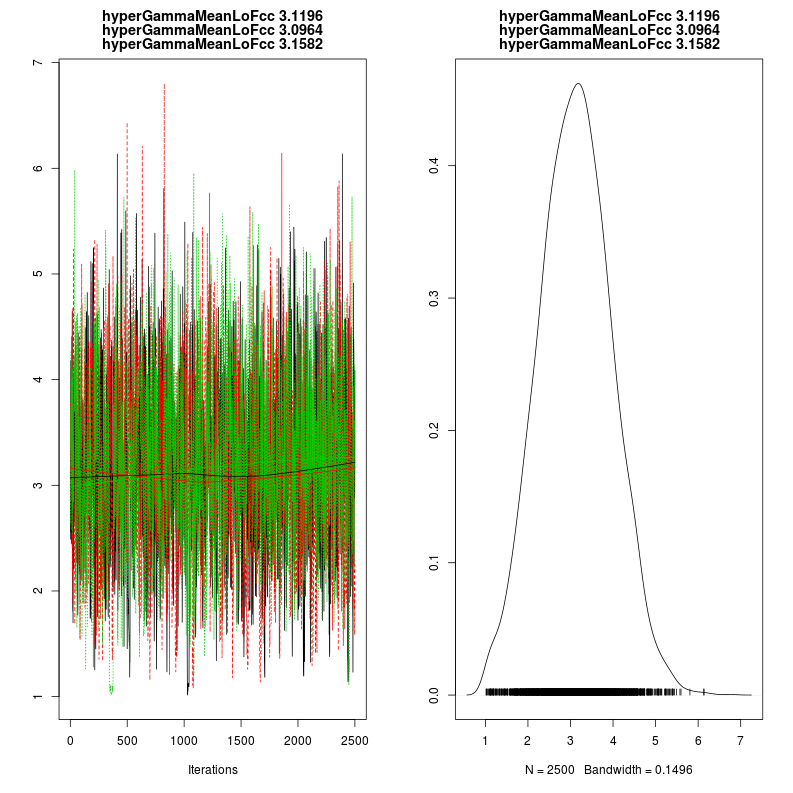

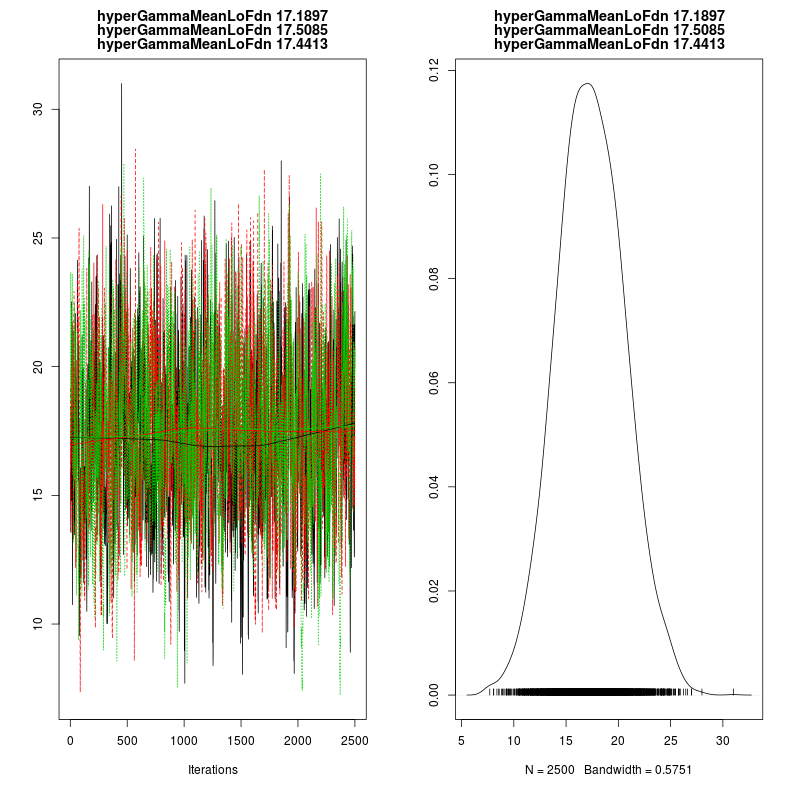

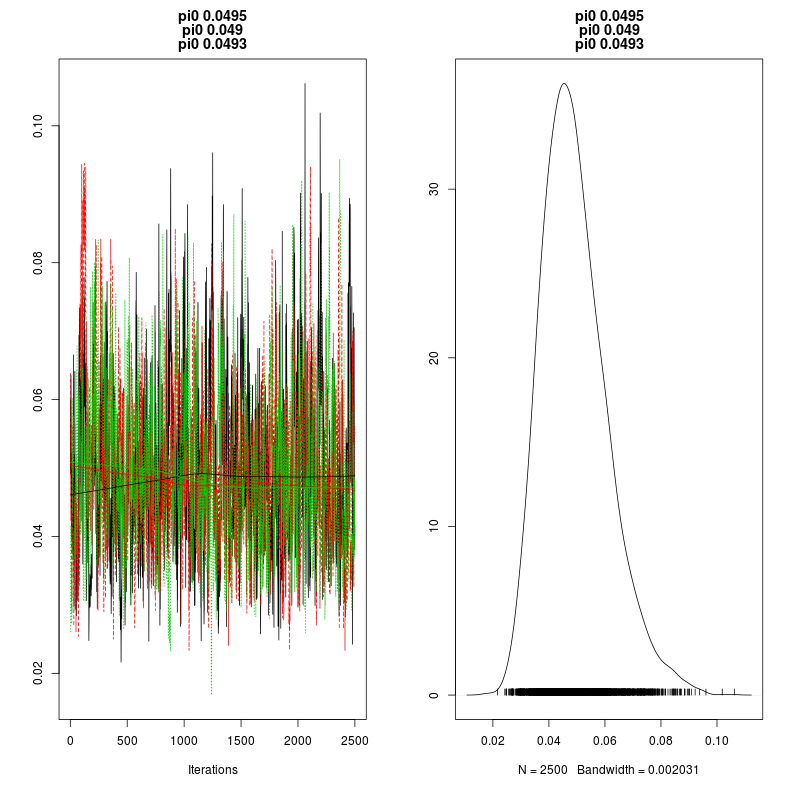

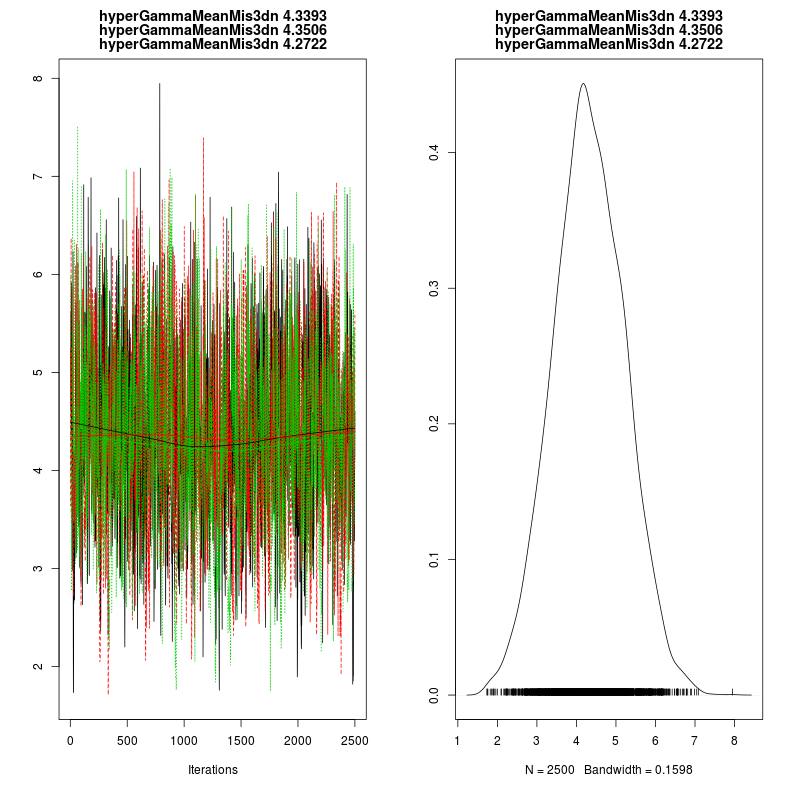

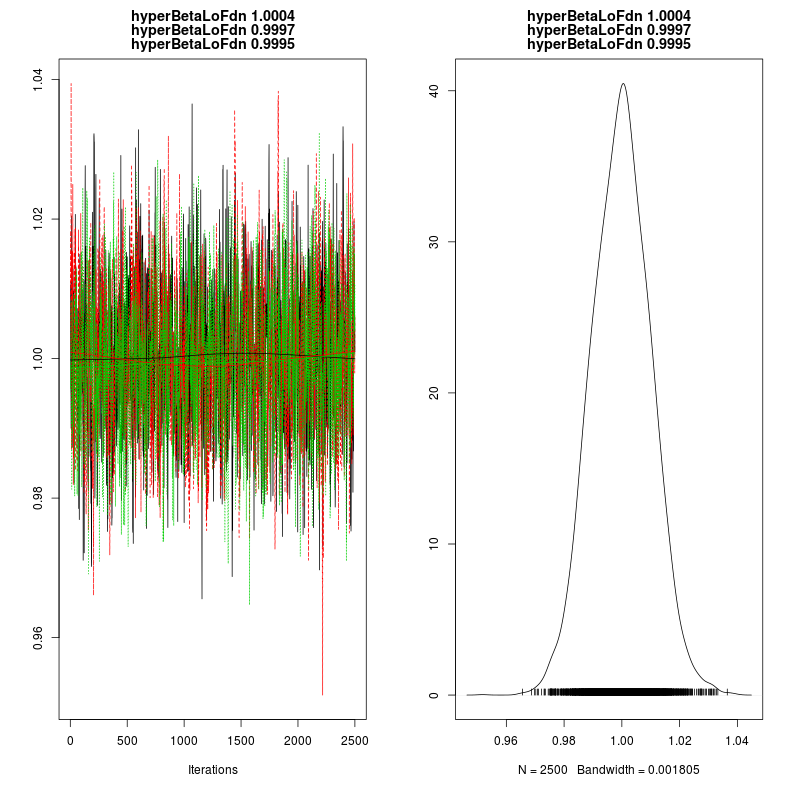

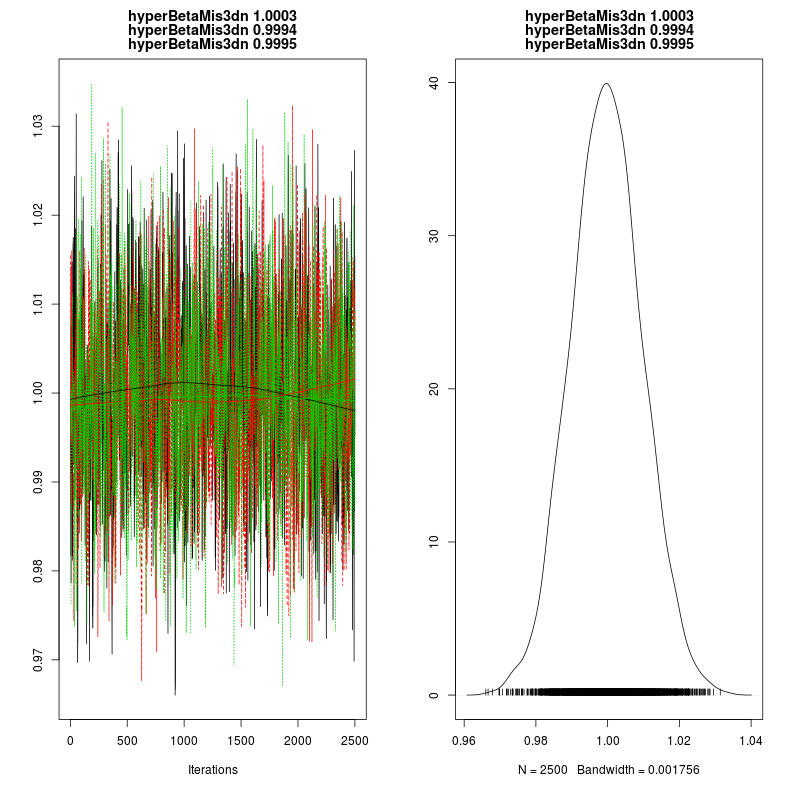

In [4]:
%%R -w 28 -h 28 -u cm
library("rjags")

for (ii in 1:length(allPar))
      
plot(s[, allPar[ii]], main = paste(allPar[ii], round(sapply(s[, allPar[ii]], mean), 4), sep = " "), cex = 0.5)

In [5]:
%%R
summary(s)


Iterations = 1:2500
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 2500 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                           Mean       SD  Naive SE Time-series SE
pi0                   4.926e-02 0.011706 0.0001352      0.0004726
hyperGammaMeanLoFdn   1.738e+01 3.231717 0.0373167      0.0948065
hyperGammaMeanMis3dn  4.321e+00 0.898058 0.0103699      0.0225251
hyperBetaLoFdn        9.999e-01 0.010145 0.0001171      0.0002460
hyperBetaMis3dn       9.997e-01 0.009917 0.0001145      0.0002272
hyperGammaMeanLoFcc   3.125e+00 0.840973 0.0097107      0.0215046
lp__                 -1.806e+04 2.959754 0.0341763      0.0825497

2. Quantiles for each variable:

                           2.5%        25%        50%        75%      97.5%
pi0                   3.038e-02  4.085e-02  4.788e-02  5.614e-02  7.646e-02
hyperGammaMeanLoFdn   1.116e+01  1.515e+01  1.732e+01  1.959e+01  2.395e+01
hyperGammaMeanMi

## Calculate Bayes Factor and gene number

In [6]:
%%R
print(head(data))
#print(head(yCaseMis3))
print(N)

    Gene  mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
1   A1BG 2.355e-05      0        0        1         0          0       0
2   A1CF 2.174e-05      0        1        2         1          1       0
3  A2LD1 6.090e-06      0        0        0         0          0       0
4    A2M 5.640e-05      0        1        5         1          0       0
5  A2ML1 5.700e-05      0        3       16         2          6       0
6 A4GALT 2.415e-05      0        0        2         1          0       0
  case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3
1         0         4          7           3
2         0         7          3           7
3         0         0          0           0
4         4        22          6           6
5         5        30          6          10
6         1         5          2           1
$dn
[1] 2231

$ca
[1] 2934

$cn
[1] 6730



In [10]:
%%R
###Calculate Bayes Factor
source("../TADA/TADA.R")

pH0 <- N$ca/(N$ca + N$cn)
bfcc <- function(ycase, ytotal, Ncase, Ncontrol,
                 lower.gamma = 1, upper.gamma = 50,
                 hyperGammaMeanCC = 1.94, hyperBetaCC = 1.98){
  bfH0 <- dbinom(ycase, ytotal, prob = pH0)
  
  
  bfH1 <- apply(cbind(ycase, ytotal), 1, function(x){
    f1 <- function(gamma0)
      dbinom(x[1], x[2], gamma0*Ncase/(gamma0*Ncase + Ncontrol))*dgamma(gamma0, shape = hyperGammaMeanCC*hyperBetaCC,
                                                                        rate = hyperBetaCC)
    return(integrate(f1, lower = lower.gamma, upper = upper.gamma)$value)
  })
  return(bfH1/bfH0)
  
}

In [11]:
%%R
pH0

[1] 0.303601


In [12]:
%%R
ycase = data$case.LoF + data$trans.LoF
ytotal =data$case.LoF + data$trans.LoF + data$ctrl.LoF + data$ntrans.LoF

BFccLoF <- bfcc(ycase = ycase, 
                ytotal = ytotal, 
                Ncase = N$ca, Ncontrol = N$cn,
               hyperGammaMeanCC = 3.1, hyperBetaCC = 4)

BFdnLoF <- bayes.factor.denovo(x = data$dn.LoF, N = N$dn, mu = data$mut.rate*mu.frac[1], 
                               gamma.mean = 17.5, beta = 1)
BFdnMis3 <- bayes.factor.denovo(x = data$dn.mis3, N = N$dn, 
                                mu = data$mut.rate*mu.frac[2], 
                               gamma.mean = 4.3, beta = 1)
BFcc <- BFccLoF

BFall <- BFccLoF*BFdnLoF*BFdnMis3


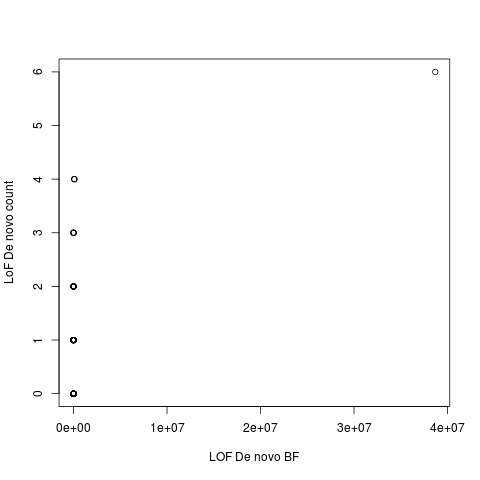

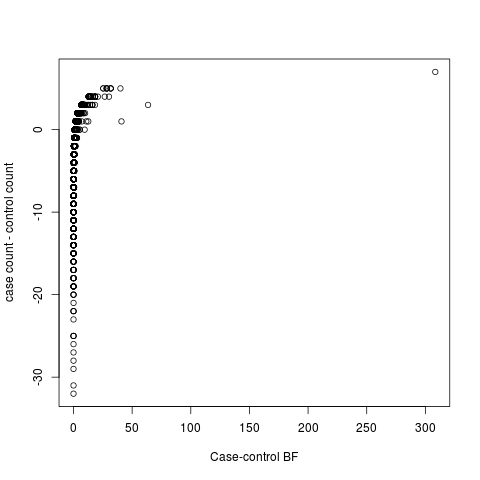

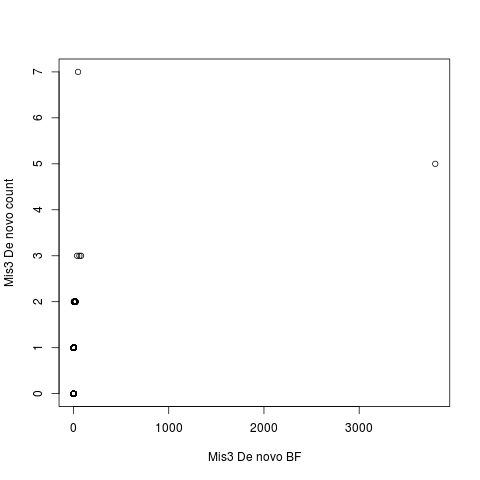

In [13]:
%%R

plot(BFcc, ycase - (ytotal - ycase) , xlab = 'Case-control BF', ylab = 'case count - control count')
plot(BFdnLoF, data$dn.LoF, xlab = 'LOF De novo BF', ylab = 'LoF De novo count')
plot(BFdnMis3, data$dn.mis3, xlab = 'Mis3 De novo BF', ylab = 'Mis3 De novo count')

In [26]:
%%R
BFall <- BFcc*BFdnLoF*BFdnMis3

data$BF <- BFall
data <- data[order(-data$BF),]
pi0 <- 1 - 0.05
data$qvalue <- Bayesian.FDR(data$BF, pi0)$FDR

data1 <- (data[data$qvalue < 0.1, ])
data1


print(dim(data1))
print(data1)


[1] 31 14
          Gene  mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
7957      IQCG 1.669e-05      0        3        6         0          0       0
13593      RGR 1.459e-05      0        0        2         0          1       0
1961  C19orf73 9.600e-06      0        0        0         1          1       0
17980    ZBTB1 2.123e-05      0        2        0         0          0       0
3588      CNFN 7.230e-06      0        0        0         0          0       0
8253     KCNU1 4.120e-05      0        4        9         3          3       0
6379     GATA4 1.624e-05      0        0        0         0          0       1
5974       FGG 1.526e-05      0        0        0         0          0       0
17128   TTC39A 2.420e-05      0        1        1         1          0       1
11390   OR5H14 9.980e-06      0        1        4         1          2       0
6759    GPR114 2.610e-05      0        0        1         0          0       0
12424    PNRC2 4.020e-06      0        0  

In [15]:
%%R
length(BFccLoF)

[1] 18735


In [16]:
%%R
Bayesian.FDR

function(BF, pi0, alpha=0.05) {
  # convert BFs to PPA (posterior probability of alternative model)
  pi <- 1-pi0
  q <- pi*BF/(1-pi+pi*BF) # PPA
  q0 <- 1 - q # posterior probability of null model
  
  # the FDR at each PPA cutoff
  n <- length(BF)
  FDR <- numeric(n)
  for (i in 1:n) FDR[i] <- sum(q0[1:i]) / i 
  
  # the cutoff
  t <- 1
  while (t <= length(q0) & mean(q0[1:t]) <= alpha) { t <- t+1 }
  return (list(FDR=FDR, ND=t))
}


In [17]:
%%R
bayes.factor.CC

function(x, N, gamma.mean, beta, rho1, nu1, rho0, nu0) {
  marglik0.CC <- evidence.null.CC(x, N, rho0, nu0)
  marglik1.CC <- evidence.alt.CC(x, N, gamma.mean, beta, rho1, nu1)
  
  BF.cn <- marglik1.CC$ctrl / marglik0.CC$ctrl
  BF.ca <- marglik1.CC$case / marglik0.CC$case
  BF <- BF.cn * BF.ca
  
  return (list(BF=BF, BF.cn=BF.cn, BF.ca=BF.ca))
}


In [18]:
%%R
xy <- cbind(ycase, ytotal - ycase)


In [19]:
%%R
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes


###########
oldBFcc <- apply(xy, 1, function(y){
    a <- NULL
    a$ca <- y[1]
    a$cn <- y[2]
    tempBF <- bayes.factor.CC(x = a, N = N, 
                             gamma.mean = 3, beta = 4,
                             rho1  = rho1[1], nu1 = nu1[1], rho0 = rho0[1], nu0 = nu0[1])
    return(tempBF)
})

In [20]:
%%R
oldBFccAll <- lapply(oldBFcc, function(x) x$BF)

In [21]:
%%R
head(oldBFccAll)    

[[1]]
          
0.6161357 

[[2]]
          
0.8370126 

[[3]]
         
0.537844 

[[4]]
          
0.3772217 

[[5]]
           
0.01704674 

[[6]]
          
0.7177512 



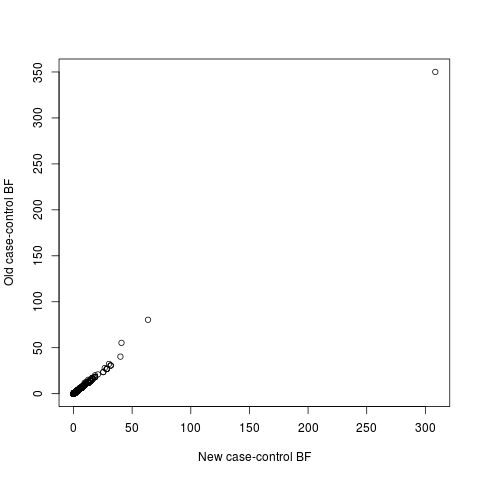

In [22]:
%%R
plot(BFccLoF, sapply(oldBFcc, function(x) x$BF), xlab = 'New case-control BF', ylab = 'Old case-control BF')

In [23]:
%%R
apply(oldBFcc, 1, range)

Error in apply(oldBFcc, 1, range) : dim(X) must have a positive length


In [24]:
%%R
head(xy)

     ycase   
[1,]     0  1
[2,]     2  3
[3,]     0  0
[4,]     2  5
[5,]     5 22
[6,]     1  2


In [25]:
%%R
x <- NULL
x$ca = 1
x$cn = 2
bayes.factor.CC(x = x, N = N,
            gamma.mean = 3, beta = 4,
                             rho1  = rho1, nu1 = nu1, rho0 = rho0, nu0 = nu0)

Error in integrate(integrand, lower = log(q.lower), upper = log(q.upper)) : 
  maximum number of subdivisions reached


In [ ]:
%%R
